# EDA и предобработка данных для задачи прогноза IBU

**Цель ноутбука:** Провести полноценный исследовательский анализ данных и базовую предобработку, чтобы подготовить данные для следующего этапа — генерации признаков (feature engineering).

---

**Структура ноутбука:**
1. Проверка установки библиотек
2. Загрузка и первичный обзор данных
3. Анализ целевой переменной `ibu`
4. Анализ качества данных (пропуски, аномалии)
5. Анализ числовых признаков (распределения, корреляции)
6. Анализ категориальных признаков
7. Тепловая карта корреляций
8. Идеи для предобработки
9. Реализация предобработки
10. Финальный датафрейм для feature engineering


In [36]:
# Импорты библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats


%matplotlib inline
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Загрузка и первичный обзор данных

**Зачем:** Понять структуру датасета, типы данных, размерность. Это базовая точка отсчёта для всего дальнейшего анализа.


In [37]:
# Загрузка данных
df = pd.read_csv("../data/beer_train.csv")

print(f"Размерность датасета: {df.shape[0]} строк × {df.shape[1]} столбцов")
print(f"\nКолонки:\n{df.columns.tolist()}")

# Первые строки датасета
df.head()

Размерность датасета: 6000 строк × 10 столбцов

Колонки:
['id', 'abv', 'available', 'description', 'glass', 'ibu', 'isOrganic', 'name', 'originalGravity', 'srm']


,id,abv,available,description,glass,ibu,isOrganic,name,originalGravity,srm
0,0,8.2,"Available at the same time of year, every year.",A Belgian-Abbey-Style Tripel that is big in al...,NaN,31.0,N,LoonyToonTripel,1.070,8
1,1,5.7,"Available at the same time of year, every year.",Covert Hops is a crafty ale. Its stealthy dark...,Pint,45.0,N,Covert Hops,1.056,35
2,2,5.8,"Available at the same time of year, every year.",This is a traditional German-style Marzen char...,Mug,25.0,N,Oktoberfest,1.048,10
3,3,5.5,Available year round as a staple beer.,A West Coast-Style Pale Ale balancing plenty o...,Pint,55.0,N,Pale Ale,1.044,5
4,4,4.8,Available year round as a staple beer.,This Bombshell has a tantalizing crisp and cle...,Pint,11.4,N,Head Turner Blonde Ale,1.045,3


In [38]:
# Типы данных и общая информация
print("Типы данных:")
print(df.dtypes)
print("\n" + "="*50)
print("\nОбщая информация о датафрейме:")
df.info()

Типы данных:
id                   int64
abv                float64
available           object
description         object
glass               object
ibu                float64
isOrganic           object
name                object
originalGravity    float64
srm                 object
dtype: object


Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               6000 non-null   int64  
 1   abv              6000 non-null   float64
 2   available        6000 non-null   object 
 3   description      5521 non-null   object 
 4   glass            3658 non-null   object 
 5   ibu              6000 non-null   float64
 6   isOrganic        6000 non-null   object 
 7   name             6000 non-null   object 
 8   originalGravity  6000 non-null   float64
 9   srm              6000 non-null   object 
dtypes: flo

In [39]:
# Описательная статистика для числовых признаков
print("Описательная статистика (числовые признаки):")
df.describe().T

Описательная статистика (числовые признаки):


,count,mean,std,min,25%,50%,75%,max
id,6000.0,2999.500000,1732.195139,0.0,1499.750,2999.50,4499.25,5999.00
abv,6000.0,6.502388,1.833054,0.2,5.200,6.00,7.40,19.70
ibu,6000.0,41.196877,28.846228,1.0,22.000,33.00,55.00,1000.00
originalGravity,6000.0,1.053993,0.021747,1.0,1.044,1.05,1.06,1.98


## 2. Анализ целевой переменной `ibu`

**Зачем:** Понимание распределения целевой переменной критично для:
- Выбора метрик оценки модели
- Понимания наличия выбросов
- Определения необходимости трансформаций (логарифмирование и т.д.)
- Оценки сложности задачи регрессии


In [40]:
# Проверка наличия целевой переменной
assert "ibu" in df.columns, "Целевая переменная 'ibu' отсутствует в датафрейме"

# Базовые статистики для IBU
print("Статистики для целевой переменной IBU:")
print(df["ibu"].describe())
print(f"\nКоличество пропусков в IBU: {df['ibu'].isna().sum()}")
print(f"Процент пропусков: {df['ibu'].isna().sum() / len(df) * 100:.2f}%")


Статистики для целевой переменной IBU:
count    6000.000000
mean       41.196877
std        28.846228
min         1.000000
25%        22.000000
50%        33.000000
75%        55.000000
max      1000.000000
Name: ibu, dtype: float64

Количество пропусков в IBU: 0
Процент пропусков: 0.00%


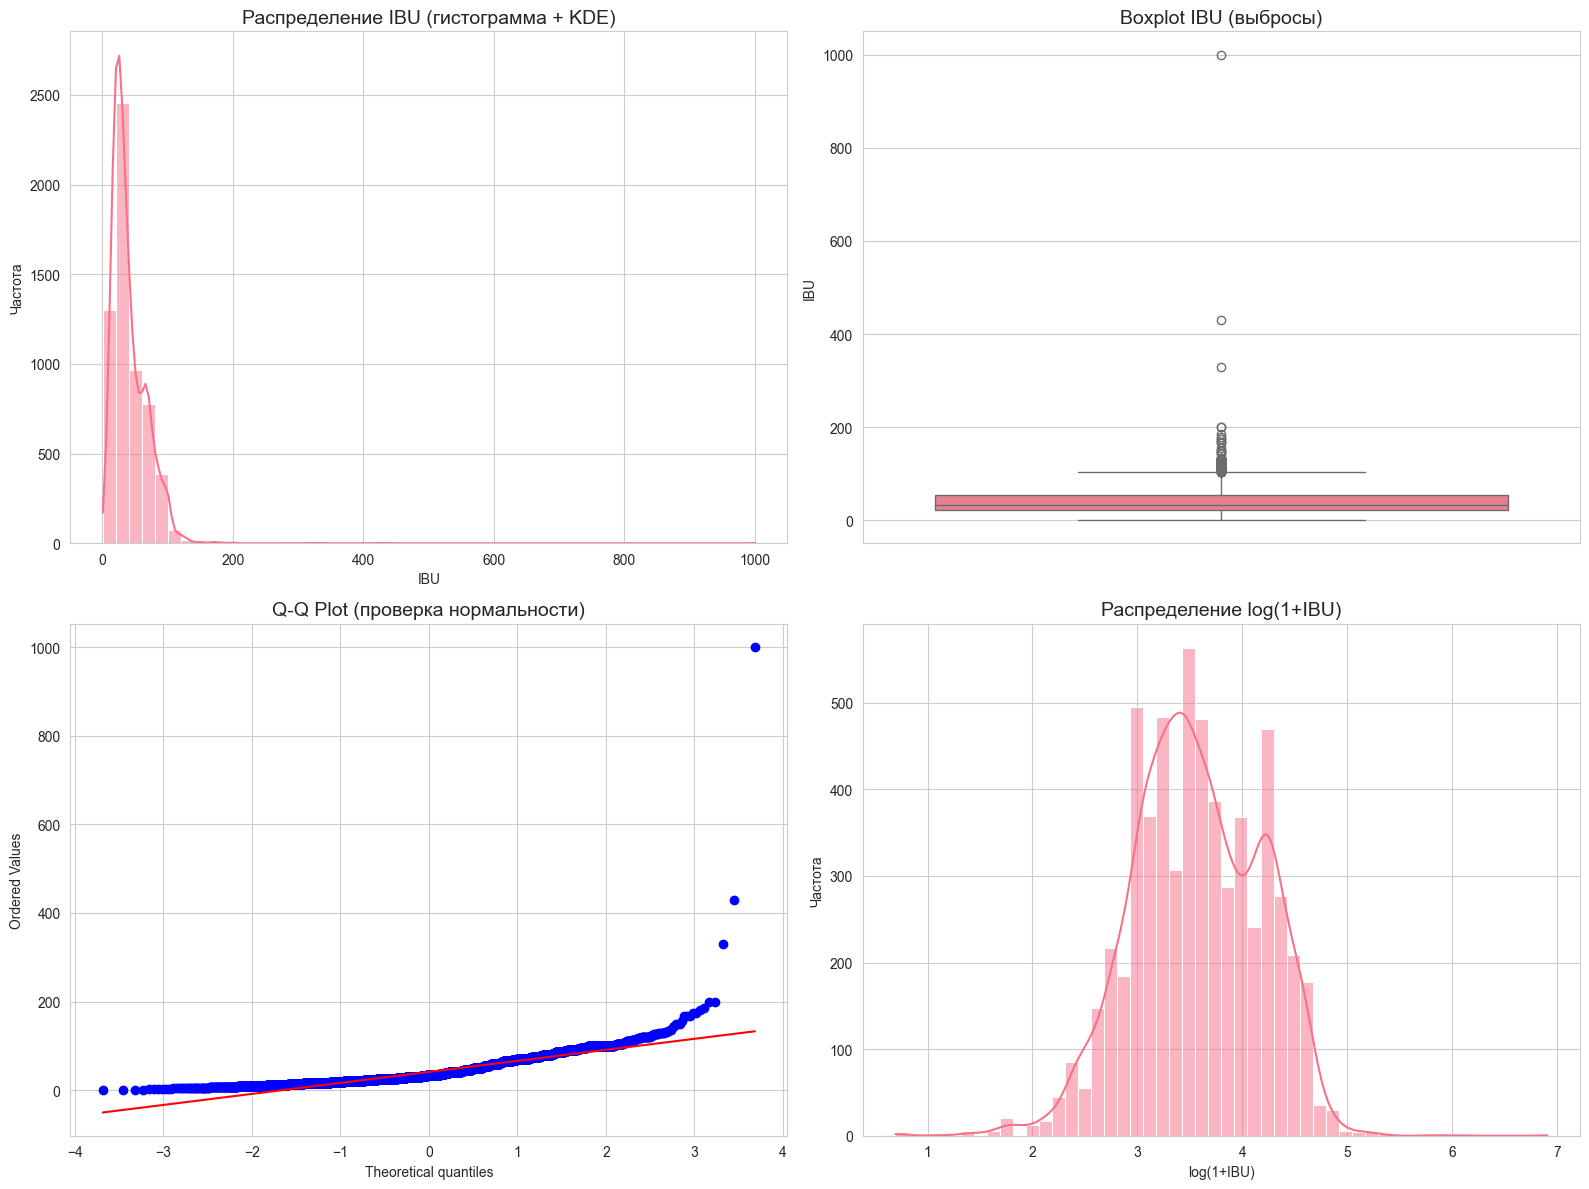

In [41]:
# Визуализация распределения IBU
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Гистограмма с KDE
sns.histplot(df["ibu"].dropna(), kde=True, bins=50, ax=axes[0, 0])
axes[0, 0].set_title("Распределение IBU (гистограмма + KDE)", fontsize=14)
axes[0, 0].set_xlabel("IBU")
axes[0, 0].set_ylabel("Частота")

# Boxplot для выявления выбросов
sns.boxplot(y=df["ibu"], ax=axes[0, 1])
axes[0, 1].set_title("Boxplot IBU (выбросы)", fontsize=14)
axes[0, 1].set_ylabel("IBU")

# Q-Q plot для проверки нормальности
stats.probplot(df["ibu"].dropna(), dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("Q-Q Plot (проверка нормальности)", fontsize=14)

# Логарифмированное распределение (для сравнения)
ibu_log = np.log1p(df["ibu"].dropna())
sns.histplot(ibu_log, kde=True, bins=50, ax=axes[1, 1])
axes[1, 1].set_title("Распределение log(1+IBU)", fontsize=14)
axes[1, 1].set_xlabel("log(1+IBU)")
axes[1, 1].set_ylabel("Частота")

plt.tight_layout()
plt.show()


### 2.1 Анализ выбросов в IBU (правый хвост распределения)

**Зачем:** Длинный правый хвост может содержать выбросы, которые искажают модель. Нужно определить, являются ли эти значения реальными данными или ошибками, и решить, как с ними работать.


In [42]:
# Анализ выбросов в IBU (правый хвост)
print("Анализ выбросов IBU:")
print("="*60)

# Метод IQR для определения выбросов
Q1 = df["ibu"].quantile(0.25)
Q3 = df["ibu"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1 (25-й процентиль): {Q1:.2f}")
print(f"Q3 (75-й процентиль): {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Нижняя граница (Q1 - 1.5*IQR): {lower_bound:.2f}")
print(f"Верхняя граница (Q3 + 1.5*IQR): {upper_bound:.2f}")

outliers_iqr = df[(df["ibu"] < lower_bound) | (df["ibu"] > upper_bound)]
print(f"\nВыбросы по методу IQR: {len(outliers_iqr)} ({len(outliers_iqr)/len(df)*100:.2f}%)")

# Экстремальные значения (выше 99-го процентиля)
p99 = df["ibu"].quantile(0.99)
extreme_values = df[df["ibu"] > p99]
print(f"\nЭкстремальные значения (выше 99-го процентиля = {p99:.2f}): {len(extreme_values)}")

# Показываем топ экстремальных значений
print("\nТоп-10 самых высоких значений IBU:")
print(df.nlargest(10, "ibu")[["name", "ibu", "abv", "srm", "description"]].to_string())


Анализ выбросов IBU:
Q1 (25-й процентиль): 22.00
Q3 (75-й процентиль): 55.00
IQR: 33.00
Нижняя граница (Q1 - 1.5*IQR): -27.50
Верхняя граница (Q3 + 1.5*IQR): 104.50

Выбросы по методу IQR: 91 (1.52%)

Экстремальные значения (выше 99-го процентиля = 114.00): 59

Топ-10 самых высоких значений IBU:
                              name     ibu    abv srm                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             description
5379                      1000 IBU  1000.0  12.20

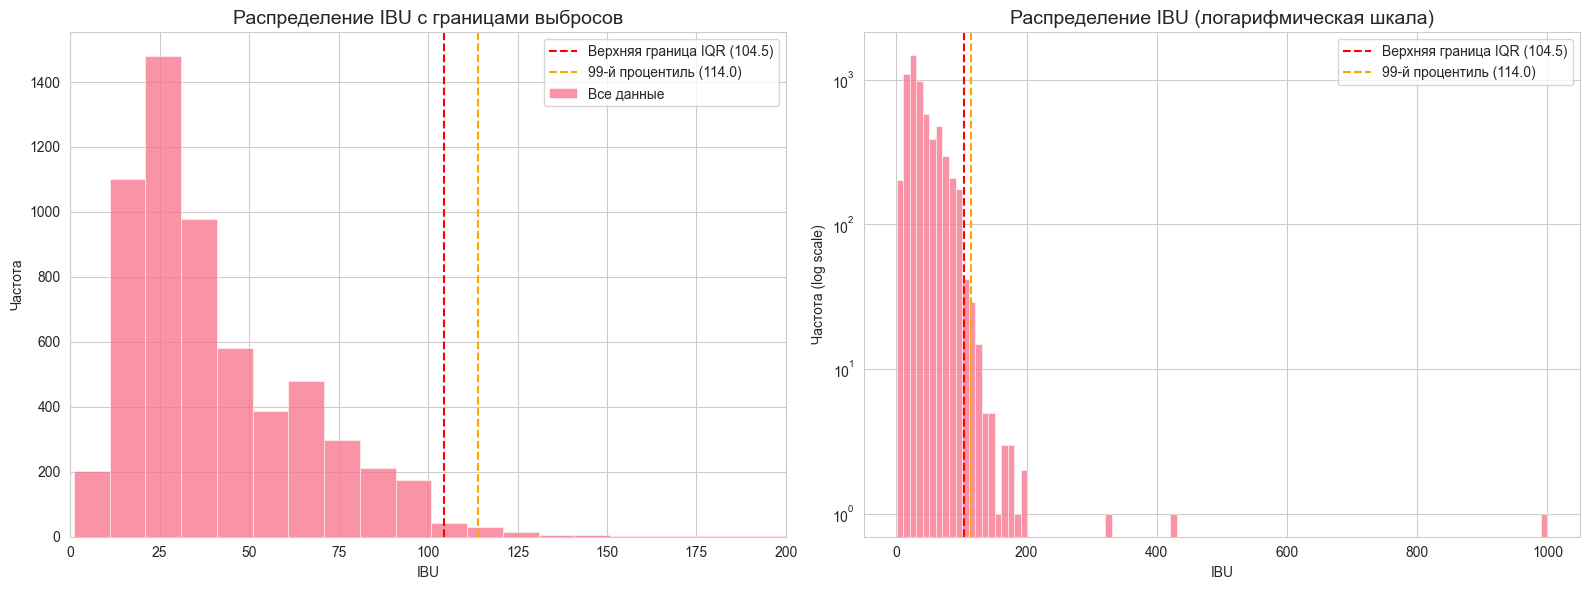

In [43]:
# Визуализация выбросов
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Распределение с выделением выбросов
sns.histplot(df["ibu"], bins=100, ax=axes[0], label="Все данные")
axes[0].axvline(upper_bound, color='r', linestyle='--', label=f'Верхняя граница IQR ({upper_bound:.1f})')
axes[0].axvline(p99, color='orange', linestyle='--', label=f'99-й процентиль ({p99:.1f})')
axes[0].set_title("Распределение IBU с границами выбросов", fontsize=14)
axes[0].set_xlabel("IBU")
axes[0].set_ylabel("Частота")
axes[0].legend()
axes[0].set_xlim(0, min(200, df["ibu"].max() * 1.1))  # Ограничиваем для лучшей визуализации

# Логарифмическая шкала для лучшего обзора хвоста
sns.histplot(df["ibu"], bins=100, ax=axes[1])
axes[1].set_yscale('log')
axes[1].axvline(upper_bound, color='r', linestyle='--', label=f'Верхняя граница IQR ({upper_bound:.1f})')
axes[1].axvline(p99, color='orange', linestyle='--', label=f'99-й процентиль ({p99:.1f})')
axes[1].set_title("Распределение IBU (логарифмическая шкала)", fontsize=14)
axes[1].set_xlabel("IBU")
axes[1].set_ylabel("Частота (log scale)")
axes[1].legend()

plt.tight_layout()
plt.show()


### 2.2 Выводы и рекомендации по выбросам IBU

**Наблюдения:**
- Распределение IBU имеет длинный правый хвост
- Максимальное значение IBU = 1000, что физически возможно, но крайне редко
- Выбросы могут быть как реальными данными (экстремально горькие пива), так и ошибками

**Рекомендации:**
1. **Не удалять выбросы автоматически** - они могут быть реальными данными (например, экстремально горькие IPA)
2. **Использовать устойчивые метрики** (MAE вместо RMSE) или трансформации (логарифмирование)
3. **Создать флаг экстремальных значений** (`ibu_extreme`) для модели
4. **Рассмотреть winsorization** (ограничение экстремальных значений) вместо удаления
5. **Проверить корректность данных** - возможно, некоторые значения требуют верификации

**Для модели:** Можно использовать log(1+IBU) как целевую переменную или добавить флаг для экстремальных значений.


## 3. Анализ качества данных: пропуски и аномалии

**Зачем:** 
- Пропуски могут требовать импутации или специальной обработки
- Аномалии в числовых признаках могут искажать модель
- Понимание паттернов пропусков помогает выбрать стратегию обработки


In [44]:
# Анализ пропусков
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_ratio = (missing_counts / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    "Количество пропусков": missing_counts,
    "Процент пропусков": missing_ratio
})

print("Топ столбцов по количеству пропусков:")
missing_df[missing_df["Количество пропусков"] > 0]


Топ столбцов по количеству пропусков:


,Количество пропусков,Процент пропусков
glass,2342,39.03
description,479,7.98


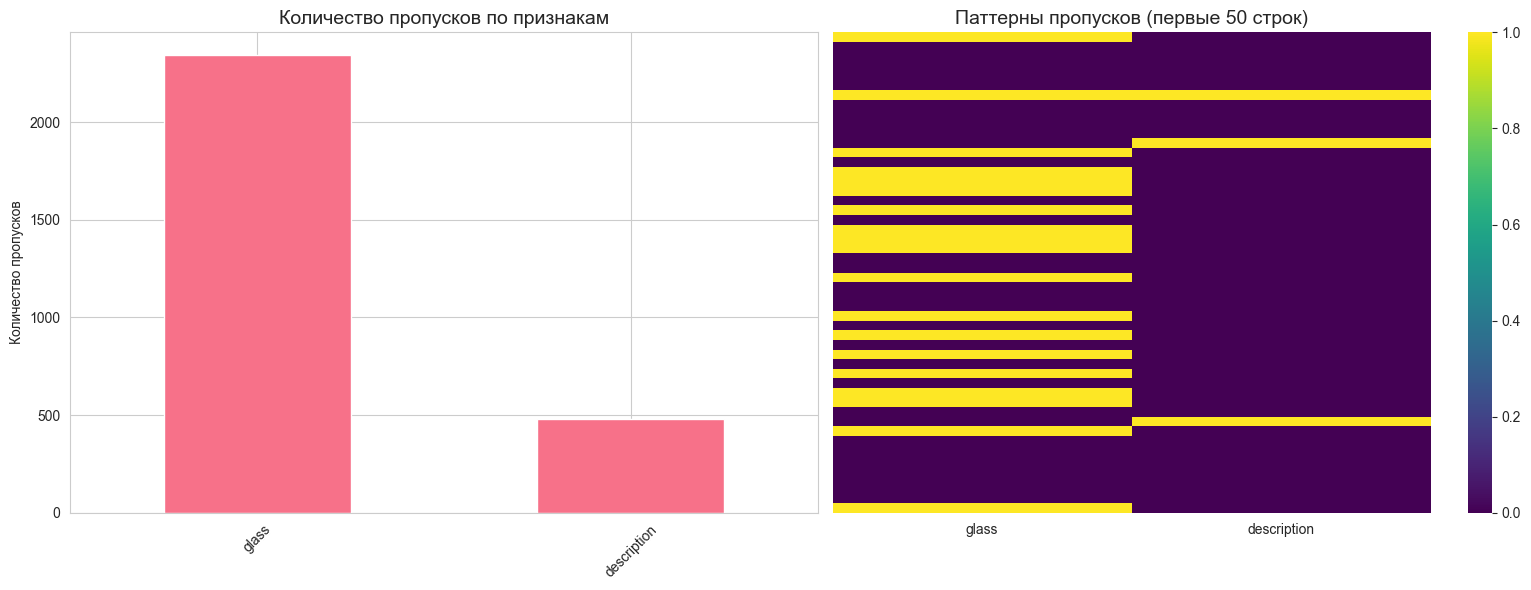

In [45]:
# Визуализация пропусков
missing_cols = missing_counts[missing_counts > 0]

if len(missing_cols) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Barplot пропусков
    missing_cols.plot(kind="bar", ax=axes[0])
    axes[0].set_title("Количество пропусков по признакам", fontsize=14)
    axes[0].set_ylabel("Количество пропусков")
    axes[0].tick_params(axis='x', rotation=45)
    
    # Heatmap пропусков (первые 50 строк для читаемости)
    sns.heatmap(df[missing_cols.index].isna().head(50), 
                yticklabels=False, cbar=True, ax=axes[1], cmap="viridis")
    axes[1].set_title("Паттерны пропусков (первые 50 строк)", fontsize=14)
    
    plt.tight_layout()
    plt.show()
else:
    print("Пропусков в данных не обнаружено")


In [46]:
# Проверка аномальных значений в числовых признаках
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print("Детальная статистика для числовых признаков (включая процентили):")
df[numeric_cols].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T


Детальная статистика для числовых признаков (включая процентили):


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
id,6000.0,2999.500000,1732.195139,0.0,59.99000,299.95,1499.750,2999.50,4499.25,5699.05,5939.01000,5999.00
abv,6000.0,6.502388,1.833054,0.2,3.80000,4.40,5.200,6.00,7.40,10.00,12.00000,19.70
ibu,6000.0,41.196877,28.846228,1.0,7.00000,12.00,22.000,33.00,55.00,90.00,114.00000,1000.00
originalGravity,6000.0,1.053993,0.021747,1.0,1.02998,1.03,1.044,1.05,1.06,1.08,1.09501,1.98


## 4. Анализ числовых признаков

**Зачем:** 
- Понимание распределений числовых признаков помогает выбрать правильные трансформации
- Выявление выбросов важно для выбора стратегии их обработки
- Анализ корреляций показывает, какие признаки наиболее информативны


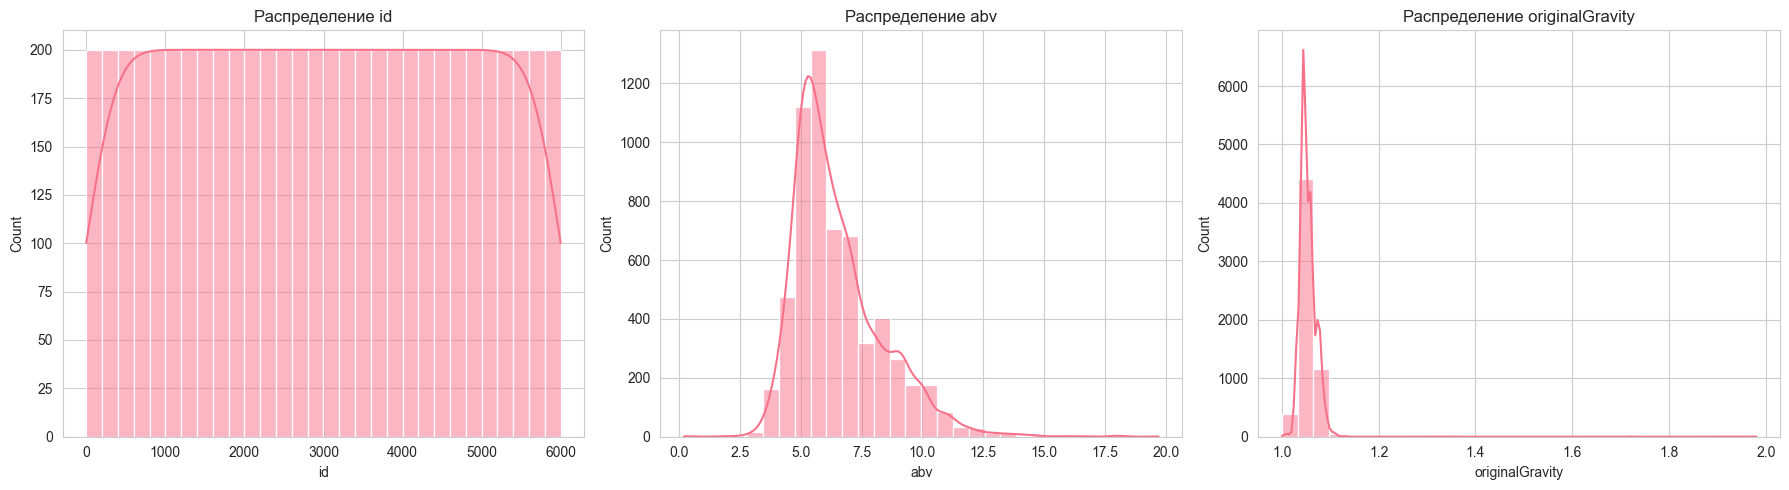

In [47]:
# Распределения числовых признаков (гистограммы)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols_no_target = [col for col in numeric_cols if col != 'ibu']

n_cols = len(numeric_cols_no_target)
n_rows = (n_cols + 2) // 3

fig, axes = plt.subplots(n_rows, 3, figsize=(18, 5*n_rows))
axes = axes.flatten() if n_cols > 1 else [axes]

for idx, col in enumerate(numeric_cols_no_target):
    sns.histplot(df[col].dropna(), kde=True, bins=30, ax=axes[idx])
    axes[idx].set_title(f"Распределение {col}", fontsize=12)
    axes[idx].set_xlabel(col)

# Скрываем лишние subplots
for idx in range(n_cols, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()


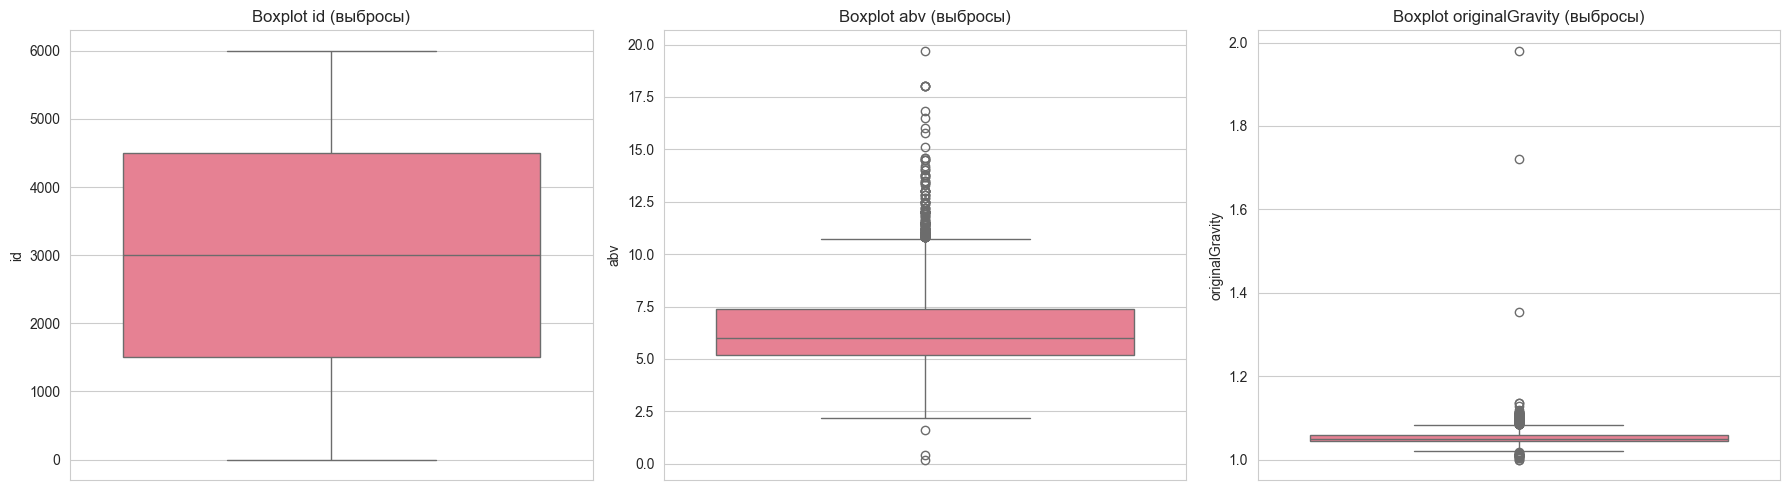

In [48]:
# Boxplots для выявления выбросов в числовых признаках
n_cols = len(numeric_cols_no_target)
n_rows = (n_cols + 2) // 3

fig, axes = plt.subplots(n_rows, 3, figsize=(18, 5*n_rows))
axes = axes.flatten() if n_cols > 1 else [axes]

for idx, col in enumerate(numeric_cols_no_target):
    sns.boxplot(y=df[col].dropna(), ax=axes[idx])
    axes[idx].set_title(f"Boxplot {col} (выбросы)", fontsize=12)
    axes[idx].set_ylabel(col)

# Скрываем лишние subplots
for idx in range(n_cols, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()


Корреляции числовых признаков с IBU:
ibu                1.000000
abv                0.473343
originalGravity    0.311092
id                 0.021574
Name: ibu, dtype: float64


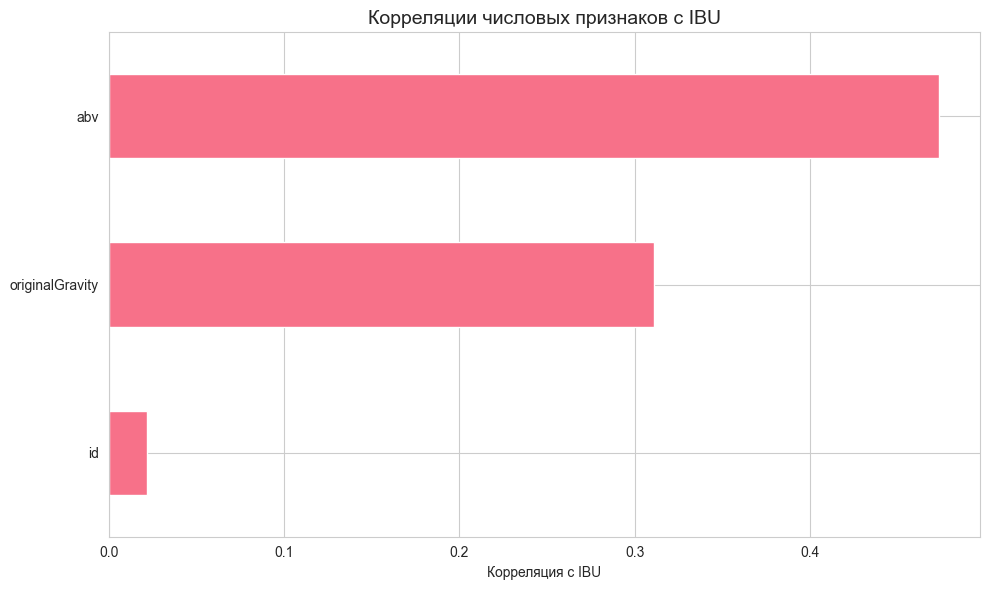

In [49]:
# Корреляции числовых признаков с целевой переменной IBU
corr_with_target = df[numeric_cols].corr()["ibu"].sort_values(ascending=False)

print("Корреляции числовых признаков с IBU:")
print(corr_with_target)

# Визуализация
plt.figure(figsize=(10, 6))
corr_no_target = corr_with_target.drop("ibu", errors="ignore")
corr_no_target.sort_values().plot(kind="barh")
plt.title("Корреляции числовых признаков с IBU", fontsize=14)
plt.xlabel("Корреляция с IBU")
plt.tight_layout()
plt.show()


## 5. Анализ категориальных признаков

**Зачем:**
- Понимание частот категорий помогает решить, какие категории объединять
- Анализ влияния категорий на целевую переменную показывает информативность признаков
- Выявление редких категорий важно для выбора стратегии кодирования


In [50]:
# Анализ категориальных признаков
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

print("Категориальные признаки:")
for col in cat_cols:
    n_unique = df[col].nunique()
    print(f"  {col}: {n_unique} уникальных значений")
    
    # Показываем топ-10 самых частых значений
    if n_unique <= 20:
        print(f"    Топ значений:")
        print(df[col].value_counts().head(10))
    else:
        print(f"    Топ-5 значений:")
        print(df[col].value_counts().head(5))
    print()


Категориальные признаки:
  available: 8 уникальных значений
    Топ значений:
available
Available year round as a staple beer.             2812
Limited availability.                              1204
Available at the same time of year, every year.    1192
Beer is not available.                              255
Available during the summer months.                 159
Available during the winter months.                 142
Available during the fall months.                   141
Available during the spring months.                  95
Name: count, dtype: int64

  description: 5502 уникальных значений
    Топ-5 значений:
description
Our award-winning barleywine boasts a dense, fruity bouquet, an intense flavor palate and a deep reddish-brown color. Its big maltiness is superbly balanced by a wonderfully bittersweet hoppiness.\r\n\r\n\r\nMalts: Two Row Pale & English Carmel\r\nYeast: Ale Yeast\r\nBittering Hops: Chinook\r\nFinishing Hops: Cascade & Centennial\r\nDry Hops: Cascade, Centennial 

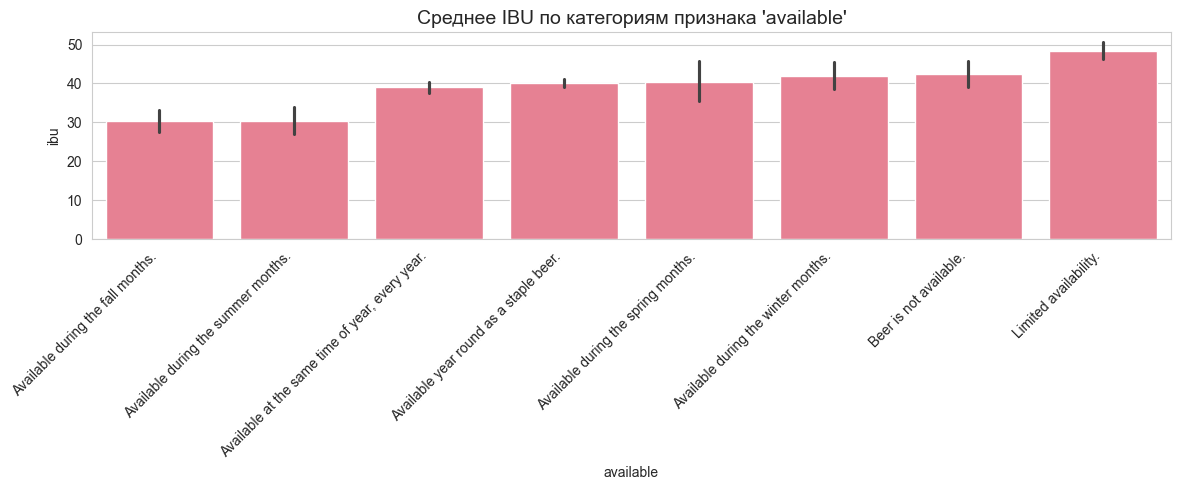


Статистика IBU по группам 'available':
                                                 count   mean    std   min  \
available                                                                    
Available at the same time of year, every year.   1192  39.08  25.18  1.06   
Available during the fall months.                  141  30.40  16.83  5.00   
Available during the spring months.                 95  40.28  25.52  1.00   
Available during the summer months.                159  30.44  22.54  3.00   
Available during the winter months.                142  41.98  21.26  7.00   
Available year round as a staple beer.            2812  40.11  25.29  1.00   
Beer is not available.                             255  42.49  27.25  1.07   
Limited availability.                             1204  48.23  39.76  3.00   

                                                    max  
available                                                
Available at the same time of year, every year.   186.0  
Avail

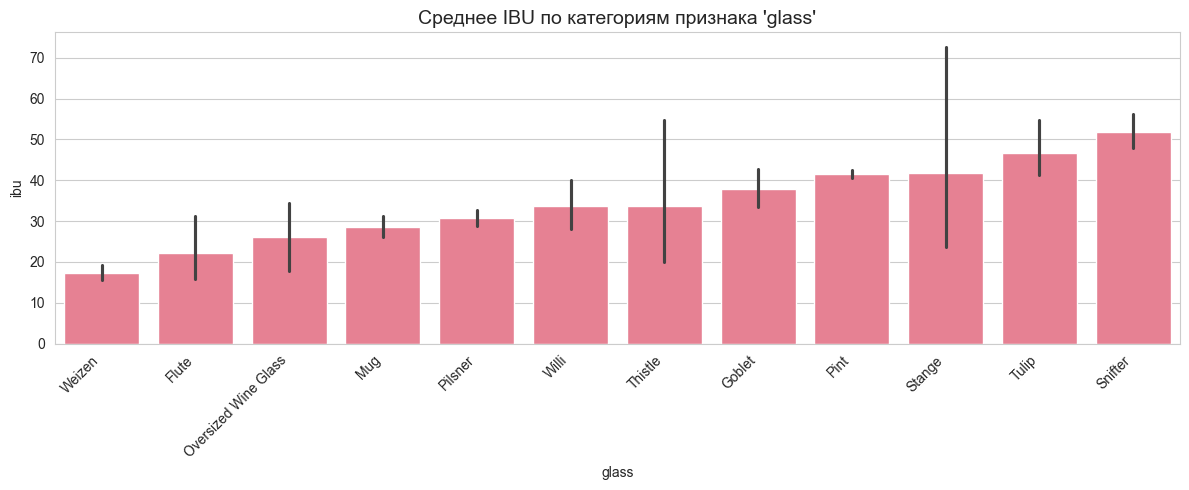


Статистика IBU по группам 'glass':
                      count   mean    std   min     max
glass                                                  
Flute                    12  22.08  15.16  10.0    66.0
Goblet                   82  37.89  21.89   6.0   100.0
Mug                      81  28.46  11.46  15.0    70.0
Oversized Wine Glass     11  26.05  15.17   9.0    57.0
Pilsner                 189  30.77  14.24   6.0    85.0
Pint                   2539  41.64  24.85   1.0   180.0
Snifter                 258  51.85  35.57   6.0   430.0
Stange                   23  41.67  64.70  12.0   330.0
Thistle                   5  33.80  23.66  15.0    75.0
Tulip                   306  46.77  61.73   3.0  1000.0
Weizen                  116  17.23  11.11   3.0    90.0
Willi                    36  33.69  18.07  15.0    75.0




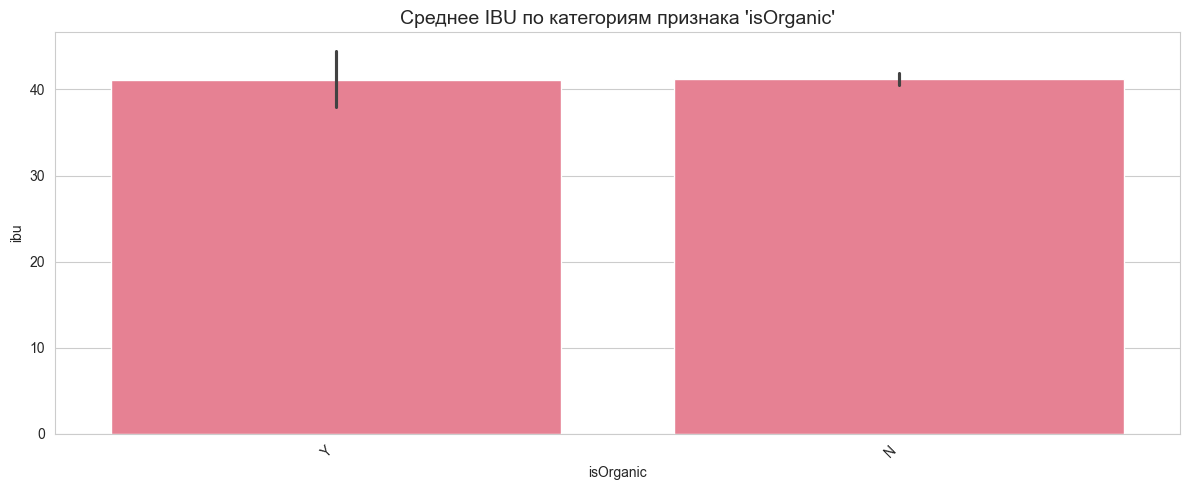


Статистика IBU по группам 'isOrganic':
           count   mean    std  min     max
isOrganic                                  
N           5804  41.20  28.99  1.0  1000.0
Y            196  41.14  24.23  5.0   100.0




In [51]:
# Влияние категориальных признаков на среднее IBU
cat_cols_small = [c for c in cat_cols if df[c].nunique() <= 30]

for col in cat_cols_small:
    plt.figure(figsize=(12, 5))
    order = df.groupby(col)["ibu"].mean().sort_values().index
    sns.barplot(data=df, x=col, y="ibu", order=order)
    plt.title(f"Среднее IBU по категориям признака '{col}'", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    
    # Статистика по группам
    print(f"\nСтатистика IBU по группам '{col}':")
    print(df.groupby(col)["ibu"].agg(["count", "mean", "std", "min", "max"]).round(2))
    print("\n" + "="*60 + "\n")


## 6. Тепловая карта корреляций

**Зачем:** 
- Визуализация всех корреляций между числовыми признаками помогает выявить мультиколлинеарность
- Понимание взаимосвязей между признаками важно для feature engineering
- Выявление сильно коррелированных признаков может помочь в выборе признаков для модели


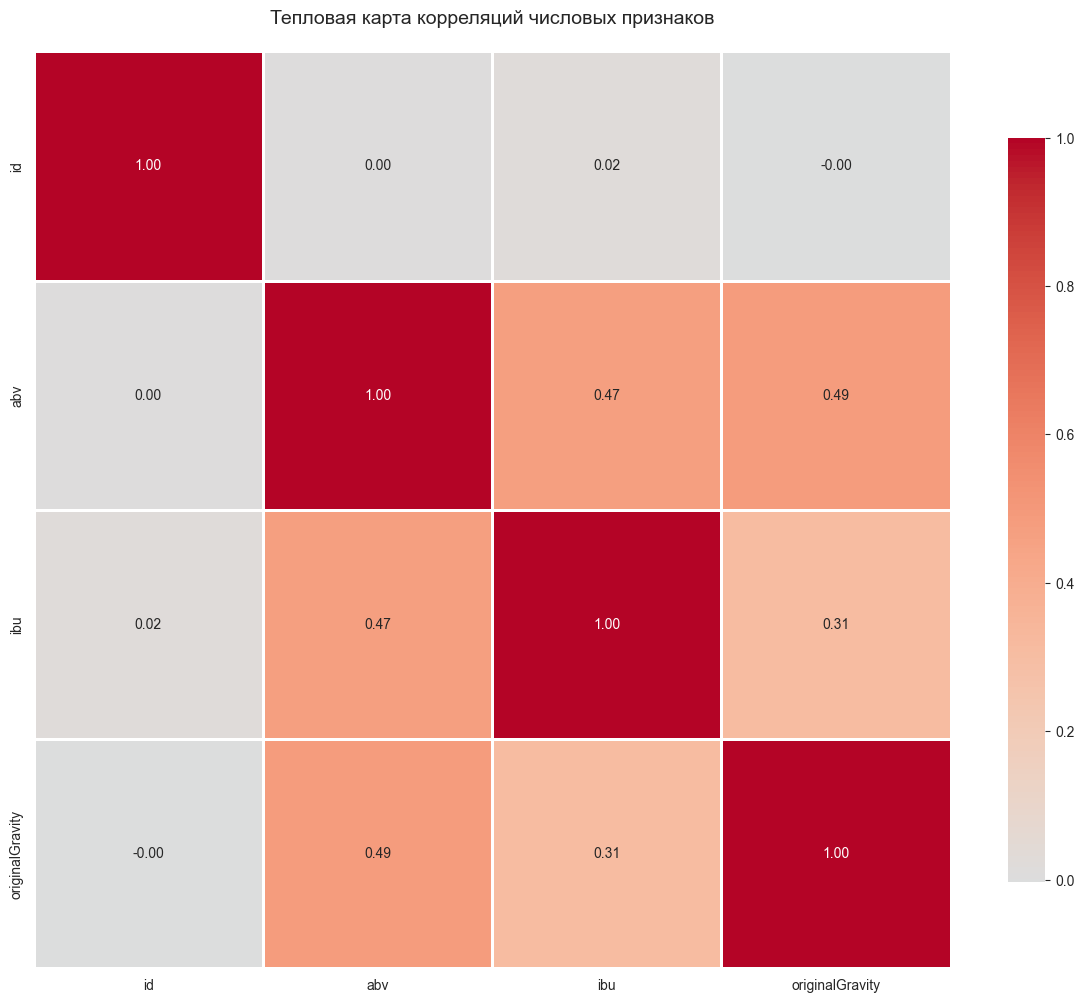

In [52]:
# Тепловая карта корреляций между всеми числовыми признаками
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title("Тепловая карта корреляций числовых признаков", fontsize=14, pad=20)
plt.tight_layout()
plt.show()


## 8. Реализация предобработки


In [53]:
# Создаём копию датафрейма для предобработки
df_processed = df.copy()

print(f"Исходная размерность: {df_processed.shape}")
print(f"Исходные колонки: {df_processed.columns.tolist()}\n")


Исходная размерность: (6000, 10)
Исходные колонки: ['id', 'abv', 'available', 'description', 'glass', 'ibu', 'isOrganic', 'name', 'originalGravity', 'srm']



In [54]:
# Шаг 1: Обработка аномальных значений в srm
if "srm" in df_processed.columns:
    # Создаём флаг для значений "Over 40"
    df_processed["srm_over_40"] = (df_processed["srm"] == "Over 40").astype(int)
    
    # Заменяем "Over 40" на числовое значение
    df_processed["srm"] = df_processed["srm"].replace("Over 40", 45)
    
    # Преобразуем в числовой тип
    df_processed["srm"] = pd.to_numeric(df_processed["srm"], errors="coerce")


### Шаг 5: Извлечение ключевых слов из текстовых полей (name и description)

**Зачем:** Вместо One-Hot Encoding для тысяч уникальных значений, извлекаем ключевые слова/фразы, которые могут указывать на:
- Тип пива (IPA, Stout, Lager, Porter, Wheat, Pilsner и т.д.)
- Вкусовые характеристики (bitter, hoppy, citrus, pine, floral и т.д.)
- Связанные с горечью термины (hop, bitter, IBU, dry hop и т.д.)


In [55]:
# Извлечение ключевых слов из name и description
import re

def extract_beer_keywords(text, keyword_lists):
    """
    Извлекает ключевые слова из текста.
    
    Parameters:
    -----------
    text : str
        Текст для анализа
    keyword_lists : dict
        Словарь с категориями ключевых слов и их списками
        
    Returns:
    --------
    dict : Словарь с бинарными флагами для каждой категории
    """
    if pd.isna(text) or text == "":
        return {cat: 0 for cat in keyword_lists.keys()}
    
    text_lower = str(text).lower()
    result = {}
    
    for category, keywords in keyword_lists.items():
        # Проверяем наличие хотя бы одного ключевого слова из категории
        found = any(keyword in text_lower for keyword in keywords)
        result[category] = 1 if found else 0
    
    return result

# Определяем ключевые слова для извлечения
beer_keywords = {
    # Типы пива
    'beer_type_ipa': ['ipa', 'india pale ale', 'imperial ipa', 'double ipa', 'triple ipa'],
    'beer_type_stout': ['stout', 'imperial stout', 'oatmeal stout', 'milk stout'],
    'beer_type_porter': ['porter', 'baltic porter'],
    'beer_type_lager': ['lager', 'pilsner', 'pils'],
    'beer_type_wheat': ['wheat', 'weizen', 'hefeweizen', 'witbier', 'wit'],
    'beer_type_ale': ['ale', 'pale ale', 'amber ale', 'brown ale'],
    'beer_type_pilsner': ['pilsner', 'pils'],
    'beer_type_saison': ['saison', 'farmhouse'],
    'beer_type_belgian': ['belgian', 'tripel', 'dubbel', 'quad'],
    
    # Характеристики, связанные с горечью
    'bitter_hop': ['hop', 'hops', 'hopped', 'hopping', 'hoppy', 'hop-forward'],
    'bitter_dry_hop': ['dry hop', 'dry-hopped', 'dry hopped', 'dry-hopping'],
    'bitter_high': ['high bitterness', 'bitter', 'bitterness', 'bittering'],
    'bitter_aggressive': ['aggressive', 'intense', 'strong hop', 'hop bomb'],
    
    # Вкусовые характеристики хмеля
    'flavor_citrus': ['citrus', 'citrusy', 'orange', 'lemon', 'grapefruit', 'lime'],
    'flavor_pine': ['pine', 'piney', 'resinous', 'resin'],
    'flavor_floral': ['floral', 'flower', 'blossom'],
    'flavor_tropical': ['tropical', 'mango', 'passion fruit', 'papaya'],
    'flavor_herbal': ['herbal', 'herb', 'grassy', 'earthy'],
    'flavor_spicy': ['spicy', 'pepper', 'peppery'],
    
    # Другие характеристики
    'flavor_malty': ['malt', 'malty', 'maltiness', 'malt character'],
    'flavor_roasted': ['roasted', 'roast', 'toasted', 'toast'],
    'flavor_chocolate': ['chocolate', 'cocoa'],
    'flavor_coffee': ['coffee'],
    'flavor_fruit': ['fruit', 'fruity', 'berry', 'berries'],
}

print("Определены категории ключевых слов:")
for category in beer_keywords.keys():
    print(f"  - {category}")


Определены категории ключевых слов:
  - beer_type_ipa
  - beer_type_stout
  - beer_type_porter
  - beer_type_lager
  - beer_type_wheat
  - beer_type_ale
  - beer_type_pilsner
  - beer_type_saison
  - beer_type_belgian
  - bitter_hop
  - bitter_dry_hop
  - bitter_high
  - bitter_aggressive
  - flavor_citrus
  - flavor_pine
  - flavor_floral
  - flavor_tropical
  - flavor_herbal
  - flavor_spicy
  - flavor_malty
  - flavor_roasted
  - flavor_chocolate
  - flavor_coffee
  - flavor_fruit


In [61]:
# Применяем извлечение ключевых слов к name и description
# ВАЖНО: используем df_processed, так как name и description не кодируются через One-Hot
print("Извлечение ключевых слов из текстовых полей...")

# Для name
name_keywords_df = df_processed["name"].apply(
    lambda x: extract_beer_keywords(x, beer_keywords)
).apply(pd.Series)

# Добавляем префикс для колонок из name
name_keywords_df.columns = [f"name_{col}" for col in name_keywords_df.columns]

# Для description
desc_keywords_df = df_processed["description"].apply(
    lambda x: extract_beer_keywords(x, beer_keywords)
).apply(pd.Series)

# Добавляем префикс для колонок из description
desc_keywords_df.columns = [f"desc_{col}" for col in desc_keywords_df.columns]

# Объединяем ключевые слова (можно суммировать или использовать максимум)
# Используем максимум: если ключевое слово найдено хотя бы в одном поле, флаг = 1
combined_keywords = pd.DataFrame()
for col in name_keywords_df.columns:
    base_col = col.replace("name_", "")
    desc_col = f"desc_{base_col}"
    if desc_col in desc_keywords_df.columns:
        # Используем максимум (OR логика)
        combined_keywords[base_col] = (name_keywords_df[col] | desc_keywords_df[desc_col]).astype(int)
    else:
        combined_keywords[base_col] = name_keywords_df[col]

# Добавляем новые признаки к датафрейму
df_encoded = pd.concat([df_encoded, combined_keywords], axis=1)

print(f"✓ Извлечено {len(combined_keywords.columns)} признаков из ключевых слов")
print(f"  Размерность после добавления ключевых слов: {df_encoded.shape}")

# Показываем статистику по извлечённым признакам
print("\nСтатистика по извлечённым ключевым словам (топ-10 по частоте):")
keyword_counts = combined_keywords.sum().sort_values(ascending=False)
print(keyword_counts.head(10))


Извлечение ключевых слов из текстовых полей...
✓ Извлечено 24 признаков из ключевых слов
  Размерность после добавления ключевых слов: (6000, 53)

Статистика по извлечённым ключевым словам (топ-10 по частоте):
beer_type_wheat    4405
bitter_hop         3416
flavor_malty       3062
beer_type_ale      2907
flavor_citrus      1368
flavor_fruit       1159
bitter_high        1150
beer_type_ipa      1090
flavor_roasted     1047
beer_type_lager     786
dtype: int64


In [63]:
# Опционально: можно также извлечь длину текста и количество слов
# ВАЖНО: используем df_processed, так как name и description не кодируются через One-Hot
df_encoded["name_length"] = df_processed["name"].str.len().fillna(0)
df_encoded["name_word_count"] = df_processed["name"].str.split().str.len().fillna(0)
df_encoded["desc_length"] = df_processed["description"].str.len().fillna(0)
df_encoded["desc_word_count"] = df_processed["description"].str.split().str.len().fillna(0)
df_encoded["has_description"] = (~df_processed["description"].isna() & (df_processed["description"] != "")).astype(int)

print("✓ Добавлены мета-признаки из текстовых полей:")
print("  - name_length, name_word_count")
print("  - desc_length, desc_word_count")
print("  - has_description")


✓ Добавлены мета-признаки из текстовых полей:
  - name_length, name_word_count
  - desc_length, desc_word_count
  - has_description


In [64]:
# Шаг 2: Импутация пропусков в числовых признаках
numeric_cols_processed = df_processed.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols_processed:
    if df_processed[col].isna().any():
        # Создаём флаг пропуска
        df_processed[col + "_was_missing"] = df_processed[col].isna().astype(int)
        
        # Заполняем медианой
        median_val = df_processed[col].median()
        df_processed[col] = df_processed[col].fillna(median_val)
        
        print(f"✓ Импутирован {col}: {df_processed[col + '_was_missing'].sum()} пропусков заполнено медианой {median_val:.2f}")

print("\nПроверка пропусков после импутации числовых признаков:")
print(df_processed[numeric_cols_processed].isna().sum().sum(), "пропусков осталось")



Проверка пропусков после импутации числовых признаков:
0 пропусков осталось


In [65]:
# Шаг 3: Импутация пропусков в категориальных признаках
cat_cols_processed = df_processed.select_dtypes(include=["object"]).columns.tolist()

for col in cat_cols_processed:
    if df_processed[col].isna().any():
        # Для glass используем "others", для остальных - "Unknown"
        fill_value = "others" if col == "glass" else "Unknown"
        df_processed[col] = df_processed[col].fillna(fill_value)
        print(f"✓ Импутирован {col}: пропуски заменены на '{fill_value}'")

print("\nПроверка пропусков после импутации категориальных признаков:")
print(df_processed[cat_cols_processed].isna().sum().sum(), "пропусков осталось")



Проверка пропусков после импутации категориальных признаков:
0 пропусков осталось


In [66]:
# Шаг 4: Кодирование категориальных признаков

# 4.1 Бинарное кодирование для isOrganic
if "isOrganic" in df_processed.columns:
    df_processed["isOrganic_bin"] = df_processed["isOrganic"].map({"Y": 1, "N": 0})
    print("✓ Закодирован isOrganic: Y→1, N→0")

# 4.2 One-Hot Encoding для категориальных признаков (БЕЗ name и description)
# name и description будем обрабатывать отдельно - извлекать ключевые слова
cat_cols_to_encode = [col for col in cat_cols_processed 
                      if col not in ["isOrganic", "name", "description"]]

if cat_cols_to_encode:
    df_encoded = pd.get_dummies(df_processed, columns=cat_cols_to_encode, drop_first=True, prefix=cat_cols_to_encode)
    print(f"✓ Применён One-Hot Encoding для {len(cat_cols_to_encode)} категориальных признаков: {cat_cols_to_encode}")
    print(f"  (name и description обрабатываются отдельно - извлечение ключевых слов)")
else:
    df_encoded = df_processed.copy()
    print("✓ Категориальных признаков для кодирования не найдено")

print(f"\nРазмерность после кодирования: {df_encoded.shape}")


✓ Закодирован isOrganic: Y→1, N→0
✓ Применён One-Hot Encoding для 2 категориальных признаков: ['available', 'glass']
  (name и description обрабатываются отдельно - извлечение ключевых слов)

Размерность после кодирования: (6000, 29)


In [67]:
# Проверка финального состояния данных
print("Финальная информация о датафрейме:")
print(f"  Размерность: {df_encoded.shape}")
print(f"  Пропуски: {df_encoded.isna().sum().sum()}")
print(f"  Типы данных:")
print(df_encoded.dtypes.value_counts())


Финальная информация о датафрейме:
  Размерность: (6000, 29)
  Пропуски: 0
  Типы данных:
bool       19
int64       4
float64     3
object      3
Name: count, dtype: int64


## 9. Финальный датафрейм для feature engineering

**Результат:** Данные готовы для следующего этапа — генерации признаков. Все базовые преобразования выполнены:
- ✅ Аномальные значения обработаны
- ✅ Пропуски импутированы с сохранением информации (флаги)
- ✅ Категориальные признаки закодированы
- ✅ Все данные в числовом формате (кроме текстовых колонок, которые можно использовать для feature engineering)


In [68]:
# Просмотр финального датафрейма
print("Первые строки обработанного датафрейма:")
df_encoded.head()


Первые строки обработанного датафрейма:


,id,abv,description,ibu,isOrganic,name,originalGravity,srm,srm_over_40,isOrganic_bin,...,glass_Oversized Wine Glass,glass_Pilsner,glass_Pint,glass_Snifter,glass_Stange,glass_Thistle,glass_Tulip,glass_Weizen,glass_Willi,glass_others
0,0,8.2,A Belgian-Abbey-Style Tripel that is big in al...,31.0,N,LoonyToonTripel,1.070,8,0,0,...,False,False,False,False,False,False,False,False,False,True
1,1,5.7,Covert Hops is a crafty ale. Its stealthy dark...,45.0,N,Covert Hops,1.056,35,0,0,...,False,False,True,False,False,False,False,False,False,False
2,2,5.8,This is a traditional German-style Marzen char...,25.0,N,Oktoberfest,1.048,10,0,0,...,False,False,False,False,False,False,False,False,False,False
3,3,5.5,A West Coast-Style Pale Ale balancing plenty o...,55.0,N,Pale Ale,1.044,5,0,0,...,False,False,True,False,False,False,False,False,False,False
4,4,4.8,This Bombshell has a tantalizing crisp and cle...,11.4,N,Head Turner Blonde Ale,1.045,3,0,0,...,False,False,True,False,False,False,False,False,False,False


In [69]:
# Список всех колонок в финальном датафрейме
print("Все колонки в обработанном датафрейме:")
print(f"Всего колонок: {len(df_encoded.columns)}")
print("\nКолонки:")
for i, col in enumerate(df_encoded.columns, 1):
    print(f"{i:3d}. {col}")


Все колонки в обработанном датафрейме:
Всего колонок: 29

Колонки:
  1. id
  2. abv
  3. description
  4. ibu
  5. isOrganic
  6. name
  7. originalGravity
  8. srm
  9. srm_over_40
 10. isOrganic_bin
 11. available_Available during the fall months.
 12. available_Available during the spring months.
 13. available_Available during the summer months.
 14. available_Available during the winter months.
 15. available_Available year round as a staple beer.
 16. available_Beer is not available.
 17. available_Limited availability.
 18. glass_Goblet
 19. glass_Mug
 20. glass_Oversized Wine Glass
 21. glass_Pilsner
 22. glass_Pint
 23. glass_Snifter
 24. glass_Stange
 25. glass_Thistle
 26. glass_Tulip
 27. glass_Weizen
 28. glass_Willi
 29. glass_others


In [75]:
df_encoded.to_csv("../data/beer_train_processed.csv", index=False)
print("✓ Обработанный датафрейм сохранён в data/beer_train_processed.csv")


✓ Обработанный датафрейм сохранён в data/beer_train_processed.csv


In [73]:
# Проверка на нестандартные значения (например, "Over 40" в srm)
print("Проверка на нестандартные значения в числовых колонках:")
for col in numeric_cols:
    if df[col].dtype == 'object':
        unique_vals = df[col].unique()
        print(f"\n{col}: найдены нечисловые значения")
        print(f"  Уникальные значения: {unique_vals[:10]}")


Проверка на нестандартные значения в числовых колонках:
